# Import libraries

In [1]:
import os
import glob
import pathlib
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Get train path and get classes name

In [2]:
base_dir = './Datasets'

train_dir = pathlib.Path(base_dir)

In [3]:
CLASS_NAMES = np.array([item.split('/')[-1] for item in glob.glob('./Datasets/CK+48_B/*')])
np.unique(CLASS_NAMES)

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype='<U8')

# Get datapath and split them

In [4]:
full_dataset = tf.data.Dataset.list_files(str(train_dir/'CK+48_B/*/*'))

In [5]:
validation_size = 0.2
dataset_size = len(list(full_dataset))
print('dataset size is {}'.format(dataset_size))
train_size = int((1-validation_size)*dataset_size)
train_dataset = full_dataset.take(train_size)
validation_dataset = full_dataset.skip(train_size)

dataset size is 28327


# Preprocessing functions

In [6]:
# def agument(image):
#     image = tf.image.resize_with_crop_or_pad(image , 60,60)
#     image = tf.image.random_crop(image , size=[55,55,3])
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)
#     return image

def normalize(image):
    image = (image / 255)
    return image

def get_label(file_path):
    parts = tf.strings.split(file_path ,os.path.sep)
    return parts[-2] == CLASS_NAMES

def load_img(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img , 3 ,expand_animations=False)
    img = tf.cast(img , tf.float32)
    return img

def load_img_with_label(image_path):
    label = get_label(image_path)
    img = load_img(image_path)
    return img , label

def resize(img , height , width):
    img = tf.image.resize(img , (height , width) , method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return img

def load_img_train(image_path):
    img , label = load_img_with_label(image_path)
#     img = agument(img)
    img = resize(img , 224 , 224)
    img = normalize(img)
    return img , label

def load_img_test(image_path):
    img , label = load_img_with_label(image_path)
    img = resize(img , 224 , 224)
    img = normalize(img)
    return img , label

# Define callbacks functions

In [7]:
# def lr_scheduler(epoch, lr):
#     decay_rate = 0.1
#     decay_step = 90
#     if epoch % decay_step == 0 and epoch:
#         return lr * decay_rate
#     return lr

# learningratescheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler , verbose=1)

def lr_scheduler(epoch, lr):
    if epoch < 20:
        return 0.001
    elif epoch < 50:
        return 0.0001
    else:
        return 0.00001
learningratescheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler , verbose=1)

In [8]:
logdir = 'facial_tensorboard/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)

In [9]:
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath='facial_checkpoint/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss')

# Load data

In [10]:
batch_size = 50
shuffle_size = 1000

In [11]:
train_dataset = train_dataset.map(load_img_train,num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(shuffle_size)
train_dataset = train_dataset.batch(batch_size,num_parallel_calls=AUTOTUNE)

validation_dataset = validation_dataset.map(load_img_test,num_parallel_calls=AUTOTUNE)
validation_dataset = validation_dataset.shuffle(shuffle_size)
validation_dataset = validation_dataset.batch(batch_size,num_parallel_calls=AUTOTUNE)

In [12]:
train_dataset

<ParallelBatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.bool, name=None))>

# Define MobileNet as pretrain model

In [13]:
base_model = tf.keras.applications.MobileNetV2(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [14]:
base_model.trainable = False

# Show one sample of data

In [15]:
def show(image):
    plt.figure()
    plt.imshow(image)
    plt.axis('off')

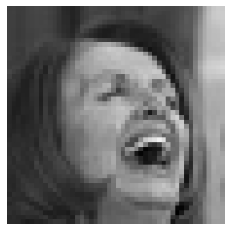

In [16]:
for i,j in train_dataset:
    show(i[1])
#     print(j[1])
    break

In [17]:
# dictionary = {0:'anger', 1:'contempt', 2:'disgust', 3:'fear', 4:'happy', 5:'sadness',6:'surprise'}
dictionary = {0:'anger', 1:'disgust', 2:'fear', 3:'happy', 4:'natural', 5:'sad',6:'surprise'}

In [18]:
num_class = len(CLASS_NAMES)

# Define FC model

In [19]:
# model=tf.keras.models.Sequential([
#                   tf.keras.layers.Conv2D(55,3,activation='relu',input_shape=(55,55,3)),
#                   tf.keras.layers.MaxPooling2D(3),
#                   tf.keras.layers.Conv2D(64,3,activation='relu'),
#                   tf.keras.layers.Conv2D(128,3,activation='relu'),
#                   tf.keras.layers.MaxPooling2D(3),
#                   tf.keras.layers.GlobalAveragePooling2D(),
#                   tf.keras.layers.Dense(256,activation='relu'),
#                   tf.keras.layers.Dropout(0.5),
#                   tf.keras.layers.Dense(num_class,activation='softmax')])

In [20]:
inputs = base_model.output
flatten = tf.keras.layers.Flatten()(inputs)
# flatten = inputs
x = tf.keras.layers.Dense(64, activation="relu")(flatten)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(num_class, activation="softmax")(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

# Fine Tune latest block MobileNet model

In [22]:
base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block_16_expand':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

# Compile model

In [24]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Plot model architecture

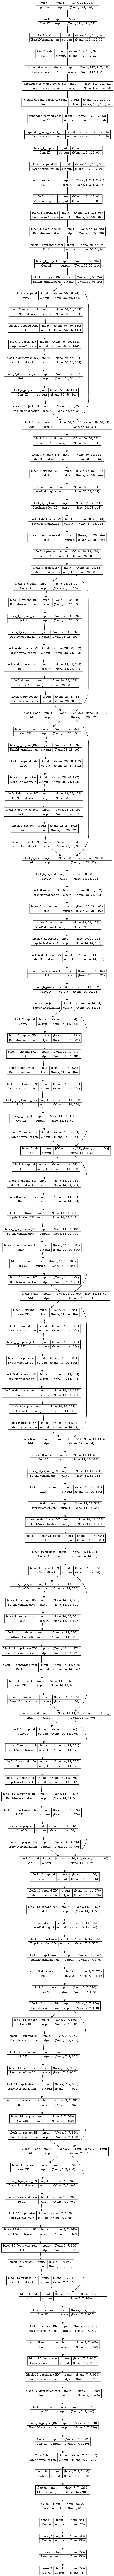

In [25]:
img_file = './architecture2.png'
tf.keras.utils.plot_model(model,to_file=img_file,show_shapes=True, show_layer_names=True)

# Run and save model

In [26]:
history = model.fit(train_dataset,epochs=100,validation_data=validation_dataset,
                    callbacks=[learningratescheduler,tensorboard_callback,ckpt_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
454/454 [==============================] - 54s 109ms/step - loss: 1.6224 - accuracy: 0.3592 - val_loss: 2.2597 - val_accuracy: 0.3648 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/100
454/454 [==============================] - 48s 105ms/step - loss: 1.4252 - accuracy: 0.4466 - val_loss: 1.5836 - val_accuracy: 0.3473 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/100
454/454 [==============================] - 47s 102ms/step - loss: 1.3189 - accuracy: 0.4993 - val_loss: 1.6933 - val_accuracy: 0.3237 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/100
454/454 [==============================] - 47s 104ms/step - loss: 1.2270 - accuracy: 0.5412 - val_loss: 1.3386 - val_accuracy: 0.5014 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/100
454/454 [=======================

Epoch 37/100
454/454 [==============================] - 46s 100ms/step - loss: 0.0320 - accuracy: 0.9899 - val_loss: 0.0245 - val_accuracy: 0.9910 - lr: 1.0000e-04

Epoch 38: LearningRateScheduler setting learning rate to 0.0001.
Epoch 38/100
454/454 [==============================] - 46s 102ms/step - loss: 0.0298 - accuracy: 0.9904 - val_loss: 0.0231 - val_accuracy: 0.9919 - lr: 1.0000e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.0001.
Epoch 39/100
454/454 [==============================] - 45s 100ms/step - loss: 0.0313 - accuracy: 0.9901 - val_loss: 0.0237 - val_accuracy: 0.9928 - lr: 1.0000e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0001.
Epoch 40/100
454/454 [==============================] - 45s 100ms/step - loss: 0.0299 - accuracy: 0.9906 - val_loss: 0.0186 - val_accuracy: 0.9926 - lr: 1.0000e-04

Epoch 41: LearningRateScheduler setting learning rate to 0.0001.
Epoch 41/100
454/454 [==============================] - 45s 100ms/step - loss: 0

Epoch 73/100
454/454 [==============================] - 45s 100ms/step - loss: 0.0109 - accuracy: 0.9957 - val_loss: 0.0087 - val_accuracy: 0.9954 - lr: 1.0000e-05

Epoch 74: LearningRateScheduler setting learning rate to 1e-05.
Epoch 74/100
454/454 [==============================] - 45s 99ms/step - loss: 0.0113 - accuracy: 0.9955 - val_loss: 0.0074 - val_accuracy: 0.9966 - lr: 1.0000e-05

Epoch 75: LearningRateScheduler setting learning rate to 1e-05.
Epoch 75/100
454/454 [==============================] - 45s 99ms/step - loss: 0.0107 - accuracy: 0.9955 - val_loss: 0.0067 - val_accuracy: 0.9972 - lr: 1.0000e-05

Epoch 76: LearningRateScheduler setting learning rate to 1e-05.
Epoch 76/100
454/454 [==============================] - 46s 101ms/step - loss: 0.0131 - accuracy: 0.9955 - val_loss: 0.0092 - val_accuracy: 0.9954 - lr: 1.0000e-05

Epoch 77: LearningRateScheduler setting learning rate to 1e-05.
Epoch 77/100
454/454 [==============================] - 46s 101ms/step - loss: 0.0117 

In [27]:
model.save('facial_exprassion_model.hdf5')